## Libraries

In [1]:
import math # for sqrt, log, exponentials
import numpy as np # for vectorization and array
import random # for random simulation
import pandas as pd # for dataframe visualization
import matplotlib.pyplot as plt # for plotting data in a graph
import copy # for making predictions
from collections import OrderedDict # ordering dictionaries
import networkx as nx # to visualize the correlation graph!
import warnings # no annoying warnings


warnings.filterwarnings('ignore') # to ignore numpy's warnings

# Problem 1: Auto-Encoders

In [2]:
def generate_data_point(sigma, bias = True):
    """
    Purpose:
    Generates a data point of at 30 dimensions.
    
    Parameters:
    sigma - a float number that alters our output, and adds more 
    noise (this should hinder the performance of our model)
    bias - a boolean to add the bias term for forward and back prop
    
    Returns:
    feature_vector - a list with a length of (dimensions + 1)
    where all elements are features
    """
    
    # intialize a feature vector of zeros
    feature_vector = np.zeros(30)
    
    # modifying x1
    feature_vector[0] = np.random.normal(0,1)
    
    # creating x4, x7, x10, x13, ... , x28
    indices_to_modify = np.array(list(range(4,28+3,3))) - 1
    for index in indices_to_modify:
        feature_vector[index] = feature_vector[index - 3] + np.random.normal(0,sigma**2)
    
    # modifying x2
    feature_vector[1] = feature_vector[0] + np.random.normal(0,sigma**2)
    
    # creating x5, x8, x11, ... , x29
    indices_to_modify = np.array(list(range(5,29+3,3))) - 1
    for index in indices_to_modify:
        feature_vector[index] = feature_vector[index - 3] + np.random.normal(0,sigma**2)
    
    # modifying x3
    feature_vector[2] = feature_vector[0] + np.random.normal(0,sigma**2)
    
    # creating x6, x9, x12, x15, ... , x30
    indices_to_modify = np.array(list(range(6,30+3,3))) - 1
    for index in indices_to_modify:
        feature_vector[index] = feature_vector[index - 3] + np.random.normal(0,sigma**2)
    
    # adding the bias term
    if bias:
        feature_vector = list(feature_vector)
        feature_vector.insert(0,1)
    
    return np.array(feature_vector)

def generate_train_data_set(training_data_size = 5000, sigma = 0.10, bias = True):
    """
    Purpose:
    To use the generate_data_point function to generate training
    data 
    
    Parameters:
    training_data_size - an integer specifying how many training data points
    you would like to generate
    bias - a boolean to add the bias term for forward and back prop
    
    sigma - a float number that alters our output
    
    Returns:
    x_train - ndarray with shape of ((dimensions + 1) x number of data points)
    """
    
    # intialize our test and training data
    training_data = []
    
    # generating the training data
    for _ in range(0,training_data_size):
        training_data.append(generate_data_point(sigma, bias))
        
    # putting our generated data into a numpy ndarray
    x_train = np.array(training_data)

    return x_train

# doing this so we do not have to calculate e
# everytime we run our activation function tanh
e = math.e

def tanh(z):
    """
    Purpose:
    Our activation function in the hidden layer
    
    Parameters:
    z - (30 x 1) vector containing random float values
    
    Returns:
    A value used for learning in the autoencoder
    """
    pos_power = e ** z
    neg_power = e ** -z
    
    return (pos_power - neg_power) / (pos_power + neg_power)

def calculate_loss(x_train, x_predicted):
    """
    Purpose:
    calculates the loss between the train data points
    and the predicted data points
    
    Parameters:
    x_train - (5000 x 30) dimensional array
    x_predicted - (5000 x 30) dimensional array
    
    Returns:
    loss - a float value indicating our error
    """
    
    # converting to numpy arrays
    x_train = np.array(x_train)
    x_predicted = np.array(x_predicted)
    
    # number of data points
    N = len(x_train)
    
    # calculating the loss
    loss = (1 / N) * np.sum( (np.linalg.norm((x_train - x_predicted)))**2 )
    
    return loss

def xavier_initialization(INPUT_NODES, HIDDEN_NODES, OUTPUT_NODES):
    """
    Parameters: 
    INPUT_NODES - an integer representing the number of input nodes in the first layer
    HIDDEN_NODES - an integer representing the number if hidden nodes in the second layer
    OUTPUT_NODES - an integer representing the number of output nodes in the third layer
    
    Returns:
    weights - a dictionary that holds two ndarrays (one for each layer except the output layer)
    
    Purpose:
    To intialize weights for our neural network, but in this case
    our autoencoder
    """

    # to hold the weights of the layers
    weights = {"Layer 1":None,"Layer 2":None}

    # building our w_vector - first build a temporary vector with all weights equal to one 
    # plus one for the bias weight
    layer_1_weights = np.ones( ((INPUT_NODES + 1) * HIDDEN_NODES) )
    layer_2_weights = np.ones( ((HIDDEN_NODES + 1) * OUTPUT_NODES) )

    # initializing the weights with Xavier intialization
    for index in range(0, len(layer_1_weights)):
            
        num_in = 0 # number of in nodes
        num_out = HIDDEN_NODES # number of out nodes, FC layers

        a = -1 * math.sqrt(6/(num_in + num_out)) # beginning of interval
        b = -a # end of interval 

        new_weight = np.random.uniform(a,b) # calculating our new weight
        layer_1_weights[index] = new_weight # putting our new weight into our weight vector
        
     # initializing the weights with Xavier intialization
    for index in range(0, len(layer_2_weights)):

        num_in = INPUT_NODES # number of in nodes
        num_out = HIDDEN_NODES # number of out nodes, FC layers

        a = -1 * math.sqrt(6/(num_in + num_out)) # beginning of interval
        b = -a # end of interval 

        new_weight = np.random.uniform(a,b) # calculating our new weight

        layer_2_weights[index] = new_weight # putting our new weight into our weight vector
        
    # assigning the weights to the weight dictionary
    weights["Layer 1"] = np.array(np.split(layer_1_weights, INPUT_NODES + 1))
    weights["Layer 2"] = np.array(np.split(layer_2_weights, HIDDEN_NODES + 1))
    
    # returning our weight dictionary
    return weights 

def forward_propogation(input_layer, weights):
    """
    Parameters:
    input_layer - ndarray of shape ((1 + INPUT_NODES) x 1)
    weights - a dictionary with ndarray of weights
    HIDDEN_NODES - an integer representing the number if hidden nodes in the second layer
    
    Returns:
    hidden_layer - ndarray of shape (1 + HIDDEN_NODES x 1)
    output_layer - ndarray of shape (INPUT_NODES x 1)
    
    Purpose:
    To compute a new hidden layer based off the weights of our model
    To compute a new output layer with the newly computed hidden layer
    """    
    # This function is vectorized using numpy
    # for incredibly fast computation!!

    # applying our weights to the input layer via dot product and the tanh activation function + bias term
    hidden_layer = np.insert(tanh(np.dot(input_layer,weights['Layer 1'])), 0 , 1)

    # applying our last weights
    output_layer = np.dot(hidden_layer,weights['Layer 2'])

    return (hidden_layer, output_layer)

def back_propogation(input_layer, hidden_layer, output_layer, weights, alpha):
    """
    Parameters:
    All the layers of the neural network and
    the learning rate alpha
    
    Returns:
    new_weights = the new computed weights of our model
    that minimize our error
    
    Purpose:
    To update the weights of our model
    using SGD (stochastic gradient descent)
    """
    
    # ~almost vectorized~ but not quite
    
    # updating the second set of weights (before the output)
    derivative_loss_to_node = (2 * (output_layer - input_layer[1:]))
    
    for index in range(0,len(hidden_layer)):
        weights['Layer 2'][index] -= alpha * hidden_layer[index] * derivative_loss_to_node

    # updating the first set of weights
    derivative_first_weight = (1 - tanh(np.dot(input_layer,weights['Layer 1'])) ** 2)
    
    for index in range(0,len(hidden_layer)):
        weights['Layer 1'][index] -= (alpha * derivative_first_weight * input_layer[index] * np.dot(derivative_loss_to_node,weights['Layer 2'][index]))
        
    return weights

def run_experiment(x_train, num_hidden_nodes, trials):
    """
    Parameters:
    x_train - an ndarray of shape (5000 x 31)
    num_hidden_nodes - an integer from 1 to 30
    trials - the number of iterations of training
    
    Returns:
    loss - a floating point number that represents
    how inaccurate our auto encoder was reconstructing our data
    
    Purpose:
    To see the results of this experiment for 
    various hidden nodes and noise in the data 
    """
    original_data = []
    predictions = []
    
    # random initialization - Xavier Edition
    weights = xavier_initialization(INPUT_NODES, num_hidden_nodes, OUTPUT_NODES)
    
    # picking random points in the training data
    for _ in range (0,trials):

        input_layer = random.choice(x_train)

        hidden_layer, output_layer = forward_propogation(input_layer, weights)
        weights = back_propogation(input_layer, hidden_layer, output_layer, weights, alpha)

        # to calculate the loss - no counting the bias term
        original_data.append(input_layer[1:])
        predictions.append(output_layer)

    loss = calculate_loss(original_data,predictions)
    return loss

### For values of $k$ between $1$ and $30$, train an auto encoder on the data, and plot the final loss as a function of $k$. What does this suggest about the dimensionality of the data set?

In [3]:
# these parameters are staying the same for all tests
# the input and output layers have the same amount of nodes 
# because we want to see if we can capture the important features
# of our data and blow it back up to its original shape

INPUT_NODES = 30 # input layer
OUTPUT_NODES = 30 # output layer 
alpha = 0.001 # learning rate

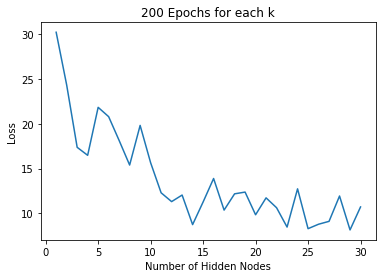

In [4]:
loss = [] # to hold the loss values for each K
x_train = generate_train_data_set(sigma = 0.10) # using the same data set for each K
for K in list(range(1,30+1)):
    loss.append(run_experiment(x_train, num_hidden_nodes = K, trials = 200))

# plotting
plt.title("200 Epochs for each k")
plt.xlabel("Number of Hidden Nodes")
plt.ylabel("Loss")
plt.plot(range(1,30+1),loss)
plt.show()

**NOTE: The above graph was trained for 200 epochs for each k.**
<br>As we increase the value of k (the number of hidden nodes) the loss *decreases*.
<br>This is because it is more challenging for the auto-encoder to encode the data in smaller dimensions.
<br>So the larger the hidden layer the more easily we can *capture* the essential features in our dataset. 
<br>However, the goal of an auto-encoder is to reduce the dimensionality of the dataset to the most important features. 
<br>It would be nice to get a small error for a small k.
<br><br>Let's repeat the experiment with a different number of epochs.

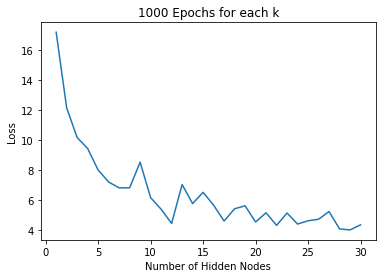

In [5]:
loss = [] # to hold the loss values for each K
x_train = generate_train_data_set(sigma = 0.10) # using the same data set for each K
for K in list(range(1,30+1)):
    loss.append(run_experiment(x_train, num_hidden_nodes = K, trials = 1000))

# plotting
plt.title("1000 Epochs for each k")
plt.xlabel("Number of Hidden Nodes")
plt.ylabel("Loss")
plt.plot(range(1,30+1),loss)
plt.show()

**NOTE: The above graph was trained for 1,000 epochs for each k.**
<br>The loss for each k is significantly less than the previous test (above graph).
<br>This is due to the increased number of epochs for this specific test.
<br>It is worthy to note that our error *drops off a cliff* after we introduce our eighth node for the hidden layer.
<br>```Thus, this suggests that the dimensionality of the dataset can easily be compressed or encoded into a smaller dimension.```
<br>With the encoded data in a lower dimensionality we have **successfully learned the essential features of the dataset.**

### How does this change as $\sigma^2$ changes, between $0$ and $2$? Why?

Let's use 1000 epochs in our next experiment, so we can compare our results to the above results.

**Epochs = 1000, and $\sigma^2$ = 0.50**

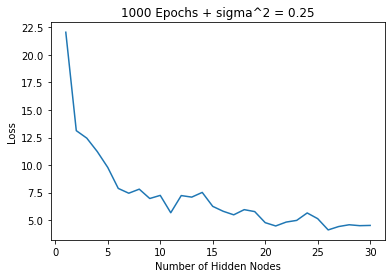

Average loss (𝜎^2 = 0.25): 7.156277681924047


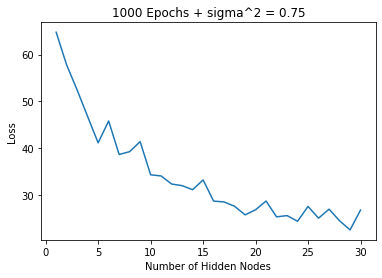

Average loss (𝜎^2 = 0.75): 34.033783077318226


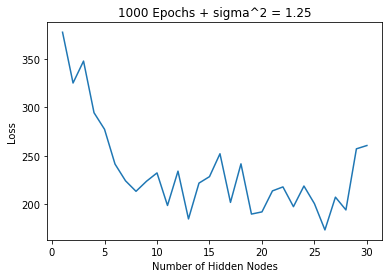

Average loss (𝜎^2 = 1.25): 234.75330200554404


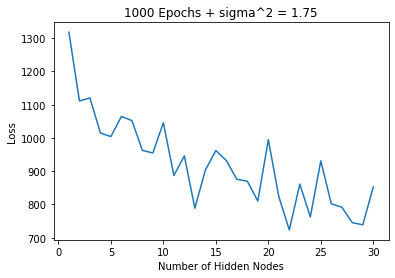

Average loss (𝜎^2 = 1.75): 921.6780165766133


In [6]:
for sigma in [0.25,0.75,1.25,1.75]:

    loss = [] # to hold the loss values for each K
    # using the same data set for each K
    x_train = generate_train_data_set(sigma = sigma) 
    
    for K in list(range(1,30+1)):
        loss.append(run_experiment(x_train, num_hidden_nodes = K, trials = 1000))

    # plotting
    plt.title("1000 Epochs + sigma^2 = " + str(sigma))
    plt.xlabel("Number of Hidden Nodes")
    plt.ylabel("Loss")
    plt.plot(range(1,30+1),loss)
    plt.show()
    
    # printing some results
    print("Average loss (𝜎^2 = " + str(sigma) + "): " + str(np.mean([x for x in loss if x != np.nan])))

With each increase of $\sigma^2$ we have an increased average loss. 
<br>This is because we generate this dataset with features that are based off other features.
<br>When we add noise to these features (increase $\sigma^2$) we change that feature and many other features!
<br>So, this change makes it incredibly difficult to learn the relavant features of the dataset.
<br>```Therefore, our average loss increases dramatically.```
<br>Take note that the model preforms better the larger the k (hidden nodes in the hidden layer). 
<br>We know this is because it is easier to encode a dataset in a larger dimensionality. 

# Problem 2: PCA

### For the data matrix $X$, compute the the principal components of the data by computing the eigenvalues and vectors of $X^TX$. What does the results suggest about the dimensionality of the data set? Is this result robust (do you get the same result doing it again on a different data set)?


In [7]:
def PCA_experiement(sigma = 0, extra_output = True):
    """
    Parameters:
    sigma - a float value that represents the noise in the
    generated dataset
    extra_output - a boolean denoting if the function should 
    print extra information about the experiment
    
    Returns:
    None
    
    Purpose:
    To show the 'true' dimensionality of the dataset
    """
    
    # generating the dataset without the bias term
    x_train = generate_train_data_set(sigma = sigma, bias = False)

    # let's mean-center the data
    x_train = x_train - np.mean(x_train)

    # computing eigen values and vectors
    eig_vals, eig_vectors = np.linalg.eig(np.dot(x_train.T,x_train)) 

    # sorting the eigen values (descending order) to get the 'better' dimensionality of the dataset
    eig_vals = sorted(eig_vals, reverse = True)

    # plotting the eigen values
    # plotting
    print("𝜎^2 = " + str(sigma))
    plt.title("Eigen Values in Descending Order")
    plt.xlabel("Eigen Number")
    plt.ylabel("Eigen Value")
    plt.scatter(range(1,30+1),eig_vals)
    plt.show()

    if extra_output:
        print("𝜎^2 = " + str(sigma))
        print("\nThe first few eigen values are...")
        for val in enumerate(eig_vals[:5]):
            print(f"{val[0]}. {val[1]}")
        
    print("\nCondition number:")
    print("K(X^T X) = " + str(max(eig_vals)/min(eig_vals)))

𝜎^2 = 0.1


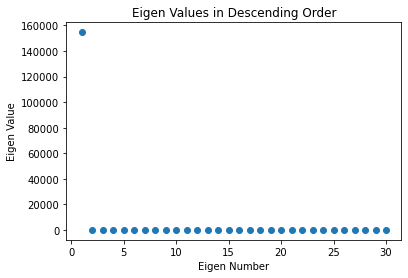

𝜎^2 = 0.1

The first few eigen values are...
0. 154684.19574560458
1. 22.96076116205328
2. 19.230051333147806
3. 5.090252011827489
4. 2.4241320789258345

Condition number:
K(X^T X) = 1416130.500040369


In [8]:
# running one PCA experiment with no noise
PCA_experiement(sigma = 0.1)

With little noise $\sigma^2 = 0.10$ the dimensionality of this dataset seems to be one.
<br>This is because there is one incredibly large eigen value term with the rest being small ~ comparatively. 
<br>Calculating the condition number of our data matrix also gives us a huge number.
<br>We know the bigger the *condition number* the more spread of our data.
<br>```Therefore, this data is 1-dimensional (very flat) and has lots of spread.```
<br><br>I will run the experiment one more time to make sure it is robust...

𝜎^2 = 0.1


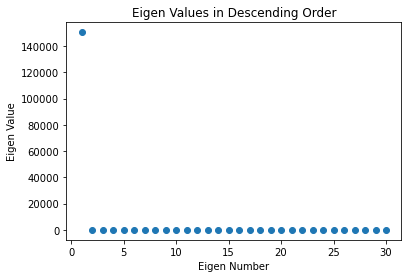

𝜎^2 = 0.1

The first few eigen values are...
0. 150449.49113854754
1. 23.289088007053564
2. 19.61537361396912
3. 5.0713447705495085
4. 2.547685811221415

Condition number:
K(X^T X) = 1353076.4381652526


In [9]:
PCA_experiement(sigma = 0.1)

As we can see we still get the same results with a different dataset.
*So, PCA is robust on this dataset.*

### How does this change as $\sigma^2$ changes, between $0$ and $2$? Why?

To see these results let's run these experiments for various $\sigma^2$.

𝜎^2 = 0.1


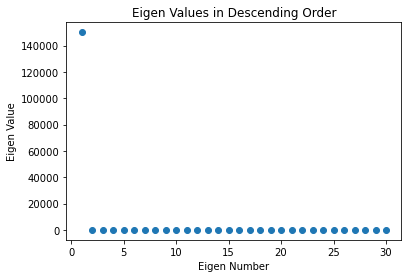


Condition number:
K(X^T X) = 1412951.2606932814
--------------------
𝜎^2 = 0.25


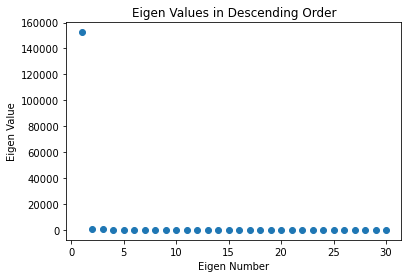


Condition number:
K(X^T X) = 36397.99712463671
--------------------
𝜎^2 = 0.75


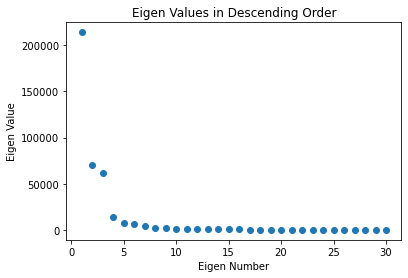


Condition number:
K(X^T X) = 642.2635480973333
--------------------
𝜎^2 = 1.25


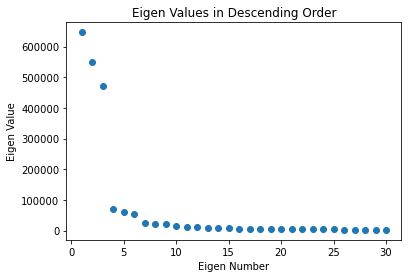


Condition number:
K(X^T X) = 334.482544850626
--------------------
𝜎^2 = 1.75


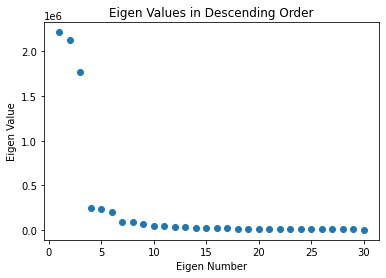


Condition number:
K(X^T X) = 609.0237466945485
--------------------
𝜎^2 = 2.0


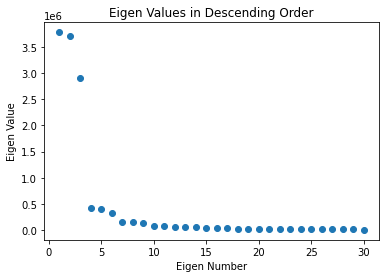


Condition number:
K(X^T X) = 894.691248280686
--------------------


In [10]:
for sigma in [0.10,0.25,0.75,1.25,1.75,2.00]:
    PCA_experiement(sigma = sigma, extra_output = False)   
    print("-"*20)

It is interesting to see as we increase $\sigma^2$ our dataset seems to be *higher dimensional*.
<br>Also, our condition number decreases too, which means our data is less spread out than before.
<br>However, the condition number for the above PCA experiments are still crazy high. 
<br>Because the lowest value for a condition number of a data matrix is one. 
<br><br>**Why does this happen?**
<br>We know that this dataset is dependant on most of the other features that come before it.
<br>The more noise we have in our dataset the more we impact all the features.
<br>So, this extra noise creates an *illusion* that our data can be represented in a higher dimension.
<br>```The added noise to the dataset confuses the principal component analysis.```
<br><br>In addition, in the graphs above as the noise increases you can see more eigen values substantially increase. 

# Problem 3: Correlation Graphs

In [11]:
def generate_correlation_graph(sigma = 0.10):
    """
    Parameters:
    sigma - a float value that denotes the noise
    in the dataset
    
    Returns:
    correlation_graph - a dictionary representing which features 
    are relevant to the other features in the dataset
    
    Purpose:
    To see what features are most important to other features.
    This will give us a good idea as to what features we can use to 
    predict other features.
    """

    # generating the dataset
    x_train = generate_train_data_set(sigma = sigma, bias = False)

    # we are represening our graph with a dictionary
    correlation_graph = dict()

    # iterating through all the features and comparing them
    # to each other
    for feature_index in range(0,30): 
        X = [] # to be our x-values

        # striping that feature from the dataset
        for index in range(0,x_train.shape[0]):
            X.append(np.delete(x_train[index],feature_index))

        X = np.array(X)
        Y = x_train[:,feature_index] # getting the feature we are comparing

        # a linear modeling predicting features with features
        w_star = np.dot(np.dot(np.linalg.inv(np.dot(X.T,X)),X.T),Y)

        # collecting the weights to add to the dictionary
        to_add = []
        for w in enumerate(w_star):
            if w[0] >= feature_index:
                to_add.append((w[0] + 1,w[1]))
            else: 
                to_add.append((w[0],w[1]))

        # sorting to_add by the second element
        # in descending order so we can see the most correlated variables
        # at the front
        to_add.sort(key = lambda x: x[1], reverse = True)

        correlation_graph[feature_index] = to_add
        
    return correlation_graph

In [12]:
# our correlation graph
correlation_graph = generate_correlation_graph()

# let's see some of the values in this graph
# looking at the first 6 features - I do not want to fill the screen 
# with lots of numbers
print("Some parts of the correlation graph:")
for key in list(correlation_graph.keys())[:6]:
    feature_number = key + 1 # the graph starts at the 0th feature
    # looking at the 2 best features that let us predict the other feature
    feature_correlations = correlation_graph[key][:2]
    
    print("\nFeature number " + str(feature_number) + " is best correlated with:")
    for corr in feature_correlations:
        print(f"Feature {corr[0] + 1} with weight {corr[1]}")

Some parts of the correlation graph:

Feature number 1 is best correlated with:
Feature 3 with weight 0.33762845503655764
Feature 4 with weight 0.33060984308347807

Feature number 2 is best correlated with:
Feature 1 with weight 0.4972437027350509
Feature 5 with weight 0.496170125266447

Feature number 3 is best correlated with:
Feature 1 with weight 0.5086982074019231
Feature 6 with weight 0.4883689218110536

Feature number 4 is best correlated with:
Feature 1 with weight 0.5145590241254345
Feature 7 with weight 0.5027832388842233

Feature number 5 is best correlated with:
Feature 8 with weight 0.5182888270447281
Feature 2 with weight 0.49733926073046797

Feature number 6 is best correlated with:
Feature 3 with weight 0.5124129418940213
Feature 9 with weight 0.5123307654145343


### Does this graph reproduce the ‘true’ dependency structure of this data? Is this robust (do you get the same result doing it again on a different data set)? What if you consider connecting each feature to the three most predictive features, or four most?

This graph does not reproduce the true dependency structure of this data.
<br>This is because the intial dataset is generated with gaussian noise that is non-linear.
<br>And we are fitting this data to a linear model, so we lose lots of crucial information in this approach. 
<br><br>This is semi-robust.
<br>I do get similar results each time I generate a new correlation graph.
<br>BUT the correlation graph is not the best representation of the structure of the data. 
<br><br>Running the experiment again (to show we get similar results)...

In [13]:
# our correlation graph
correlation_graph = generate_correlation_graph()

# let's see some of the values in this graph
# looking at the first 6 features - I do not want to fill the screen 
# with lots of numbers
print("Some parts of the correlation graph:")
for key in list(correlation_graph.keys())[:6]:
    feature_number = key + 1 # the graph starts at the 0th feature
    # looking at the 2 best features that let us predict the other feature
    feature_correlations = correlation_graph[key][:2]
    
    print("\nFeature number " + str(feature_number) + " is best correlated with:")
    for corr in feature_correlations:
        print(f"Feature {corr[0] + 1} with weight {corr[1]}")

Some parts of the correlation graph:

Feature number 1 is best correlated with:
Feature 4 with weight 0.3294993067661056
Feature 3 with weight 0.3280846547087791

Feature number 2 is best correlated with:
Feature 5 with weight 0.5132275710062731
Feature 1 with weight 0.49412411354009533

Feature number 3 is best correlated with:
Feature 1 with weight 0.49879047201738846
Feature 6 with weight 0.477982308982698

Feature number 4 is best correlated with:
Feature 1 with weight 0.5005027605267408
Feature 7 with weight 0.49142369604592506

Feature number 5 is best correlated with:
Feature 8 with weight 0.4960279055752529
Feature 2 with weight 0.49433214961505434

Feature number 6 is best correlated with:
Feature 9 with weight 0.49446887997754985
Feature 3 with weight 0.48728472589132205


If we consider connecting each feature to the three or four most predictive features, then our approach becomes more robust.
<br>But not too much more robust because we are fitting a linear model to a non-linear dataset. 
<br>In this new approach, we do have more information we can work with because we have more features that can help us predict other features. 
<br><br>Running this experiment below and showing the first four most correlated features...

In [14]:
# our correlation graph
correlation_graph = generate_correlation_graph()

# let's see some of the values in this graph
# looking at the first 6 features - I do not want to fill the screen 
# with lots of numbers
print("Some parts of the correlation graph:")
for key in list(correlation_graph.keys())[:3]:
    feature_number = key + 1 # the graph starts at the 0th feature
    # looking at the 2 best features that let us predict the other feature
    feature_correlations = correlation_graph[key][:4]
    
    print("\nFeature number " + str(feature_number) + " is best correlated with:")
    for corr in feature_correlations:
        print(f"Feature {corr[0] + 1} with weight {corr[1]}")

Some parts of the correlation graph:

Feature number 1 is best correlated with:
Feature 2 with weight 0.34335004997583973
Feature 4 with weight 0.3383260650359893
Feature 3 with weight 0.3288641564548587
Feature 23 with weight 0.029066293532994836

Feature number 2 is best correlated with:
Feature 1 with weight 0.5185744154570895
Feature 5 with weight 0.49648442632854484
Feature 26 with weight 0.027962934576643117
Feature 8 with weight 0.019144871820967913

Feature number 3 is best correlated with:
Feature 1 with weight 0.5056900178919277
Feature 6 with weight 0.4933078367168092
Feature 26 with weight 0.026478386226464812
Feature 17 with weight 0.02239789745968568



Graph with 2 most correlated features.


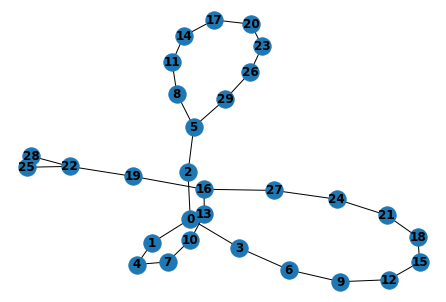


Graph with 3 most correlated features.


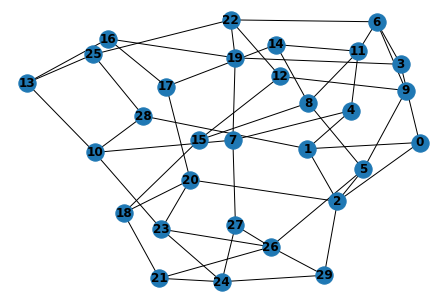


Graph with 4 most correlated features.


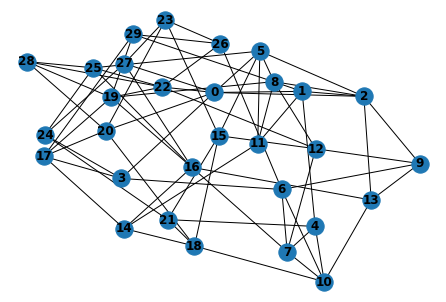

In [15]:
# visualizing a correlation graph with the 2,3,4 most predictive features
for pop in [2,3,4]:
    
    G = nx.Graph()

    # our correlation graph
    correlation_graph = generate_correlation_graph()

    for key in list(correlation_graph.keys()):
        feature_number = key + 1 # the graph starts at the 0th feature
        # looking at the 2 best features that let us predict the other feature
        feature_correlations = correlation_graph[key][:pop]

        # adding edges
        for vertex in feature_correlations:
            G.add_edge(key, vertex[0])

    print(f"\nGraph with {pop} most correlated features.")
    nx.draw(G, with_labels = True, font_weight = 'bold')
    plt.show()

From the graphs above we can see that the more features we consider the more dense those graphs become.

### Consider building this graph by connecting each feature to the other features that have a weight in the model larger than some threshold. How does the resulting graph depend on the threshold taken? Are you able to reconstruct the true dependency graph?

<br>Let us do the same process from above, but consider weights in our graph. 



Graph with 4 most correlated features with threshold = 0.25.


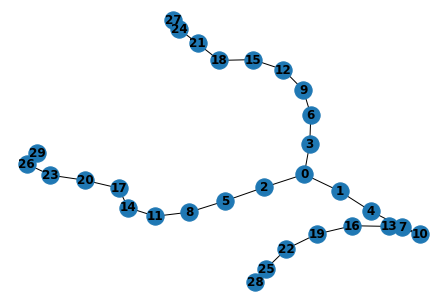


Graph with 4 most correlated features with threshold = 0.5.


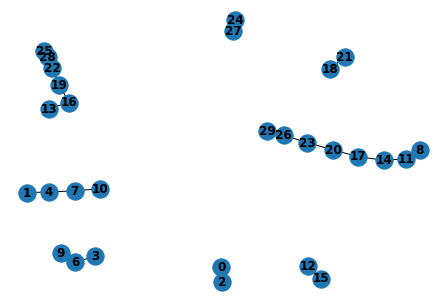


Graph with 4 most correlated features with threshold = 0.7.


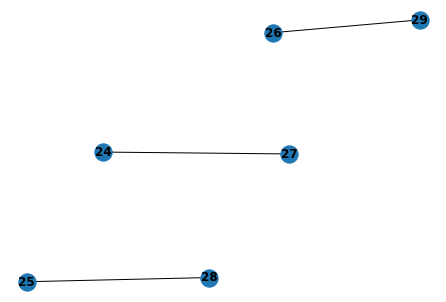

In [16]:
# visualizing a correlation graph with the 4 most predictive features
for threshold in [0.25,0.50,0.70]:
    
    G = nx.Graph()

    # our correlation graph
    correlation_graph = generate_correlation_graph()

    for key in list(correlation_graph.keys()):
        feature_number = key + 1 # the graph starts at the 0th feature
        # looking at the 2 best features that let us predict the other feature
        feature_correlations = correlation_graph[key][:4]

        # adding edges
        for vertex in feature_correlations:
            if vertex[1] > threshold:
                G.add_weighted_edges_from([(key, vertex[0], vertex[1])])
                
    print(f"\nGraph with 4 most correlated features with threshold = {threshold}.")
    nx.draw(G, with_labels = True, font_weight = 'bold')
    plt.show()

The resulting density or sparsity of the graph above is determined by the chosen threshold.
<br>I have displayed graphs for various thresholds above.
<br>The closer the threshold is to one, the sparser our graph is.
<br>This is because there are rarely features that are almost 100% dependant on each other.
<br>On the other hand, if the threshold is close zero we get most of the nodes in the graph 
<br>because the minimum correlation for a feature to another feature is zero.
<br><br>We cannot reconstruct the true dependency of this graph.
<br>*The linear model fails to capture the relationships between a dataset that is non-linear.*
<br>**The graph below is the best we can do** (Fully connected graph of 30 nodes).

Threshold = 0.


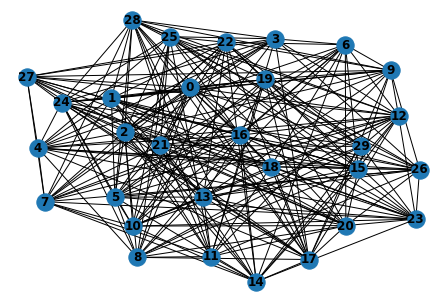

In [17]:
# visualizing a correlation graph with all features!
for threshold in [0]:
    
    G = nx.Graph()

    # our correlation graph
    correlation_graph = generate_correlation_graph()

    for key in list(correlation_graph.keys()):
        feature_number = key + 1 # the graph starts at the 0th feature
        # looking at the 2 best features that let us predict the other feature
        feature_correlations = correlation_graph[key]

        # adding edges
        for vertex in feature_correlations:
            if vertex[1] >= threshold:
                G.add_weighted_edges_from([(key, vertex[0], vertex[1])])
                
    print(f"Threshold = {threshold}.")
    nx.draw(G, with_labels = True, font_weight = 'bold')
    plt.show()

### How does this change as $\sigma^2$ changes, between $0$ and $2$? Why?

We are setting the threshold to zero, and slowly changing the noise between 0 and 2 in the below experiment.

Threshold = 0.5, 𝜎^2 = 0.1


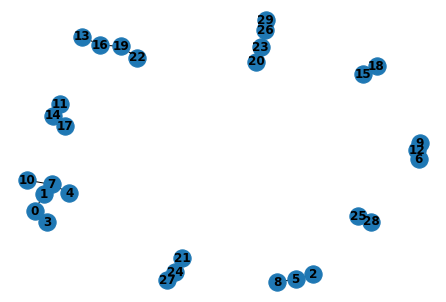

Threshold = 0.5, 𝜎^2 = 0.5


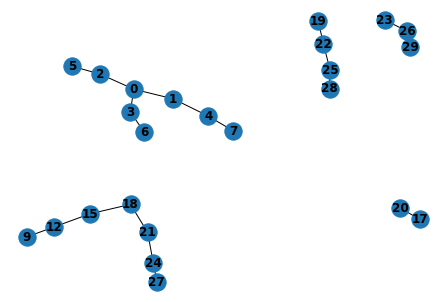

Threshold = 0.5, 𝜎^2 = 1.5


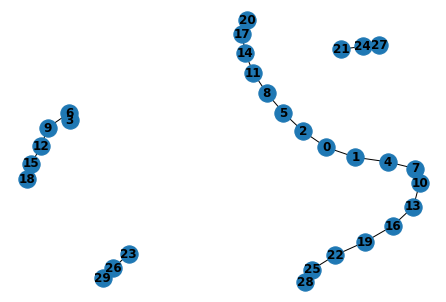

Threshold = 0.5, 𝜎^2 = 2.0


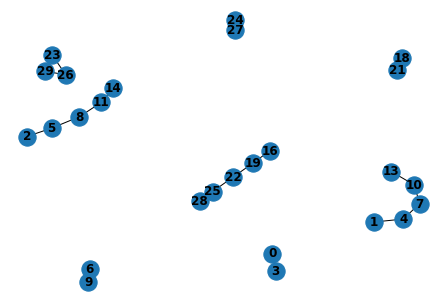

In [18]:
# visualizing a correlation graph with NOISE AND THRESHOLD = 0.50
for sigma in [0.10,0.50,1.50,2.0]:
    
    G = nx.Graph()

    # our correlation graph
    correlation_graph = generate_correlation_graph(sigma = sigma)

    for key in list(correlation_graph.keys()):
        feature_number = key + 1 # the graph starts at the 0th feature
        # looking at the 2 best features that let us predict the other feature
        feature_correlations = correlation_graph[key]

        # adding edges
        for vertex in feature_correlations:
            if vertex[1] > 0.50:
                G.add_weighted_edges_from([(key, vertex[0], vertex[1])])
                
    print(f"Threshold = {0.50}, 𝜎^2 = {sigma}")
    nx.draw(G, with_labels = True, font_weight = 'bold')
    plt.show()

As we increase the noise our correlation graph seems to become *confused!*
<br>This happens because the random noise tricks the linear model to *think* some features 
<br>are correlated with others when in reality they are not!
<br><br>So, we get random patches of connected nodes that are 'related' to each other. 
<br>```Hence, the noise confuses our correlation graph and gives us horrible results.```